In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score, roc_curve, auc

In [2]:
df = pd.read_csv('emails.csv')
df.head()

,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1


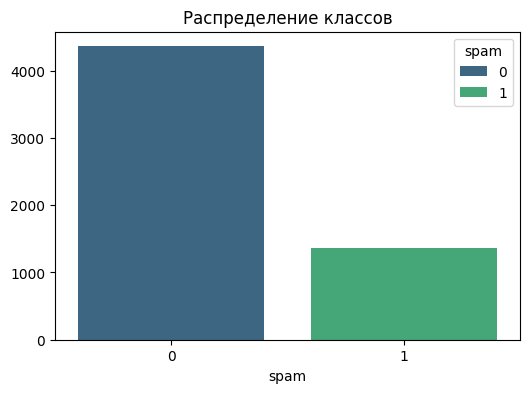

In [3]:
class_counts = df['spam'].value_counts()

plt.figure(figsize=(6,4))
sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis', hue=class_counts.index)
plt.title('Распределение классов')
plt.show()

In [37]:
df.isna().sum()

text     0
spam     0
words    0
class    0
dtype: int64

In [38]:
df['words'] = df['text'].apply(lambda text: list(set(text.lower().split())))
df['class'] = df['spam'].apply(lambda x: 'spam' if x == 1 else 'ham')
df.head()

,text,spam,words,class
0,Subject: naturally irresistible your corporate...,1,"[become, hard, the, with, its, hand, structure...",spam
1,Subject: the stock trading gunslinger fanny i...,1,"[chameleon, superior, the, pirogue, subject:, ...",spam
2,Subject: unbelievable new homes made easy im ...,1,"[minute, wanting, 454, the, 3, rate, subject:,...",spam
3,Subject: 4 color printing special request add...,1,"[mail, canyon, printable, ), now, advertisemen...",spam
4,"Subject: do not have money , get software cds ...",1,"[along, cds, death, old, the, with, get, subje...",spam


In [39]:
X = df.drop(['spam'], axis=1)
y = df['spam']

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=41)

In [92]:
word_freq_dict = {}

for i in X_train.index:
    for word in X_train['words'][i]:
        if word not in word_freq_dict:
            word_freq_dict[word] = {'spam': 1 , 'ham' : 1}
        word_freq_dict[word][X_train['class'][i]] += 1


dict(list(word_freq_dict.items())[:10])

{'text': {'spam': 44, 'ham': 53},
 '3664': {'spam': 1, 'ham': 6},
 'the': {'spam': 878, 'ham': 3197},
 'with': {'spam': 534, 'ham': 2125},
 'password': {'spam': 12, 'ham': 82},
 'there': {'spam': 135, 'ham': 794},
 'article': {'spam': 6, 'ham': 94},
 'january': {'spam': 8, 'ham': 159},
 'only': {'spam': 229, 'ham': 445},
 'of': {'spam': 794, 'ham': 2656}}

In [42]:
count_spam_train = y_train.value_counts()[1]
count_ham_train = y_train.value_counts()[0]
prob_spam_train = count_spam_train / y_train.shape[0]
prob_ham_train = count_ham_train / y_train.shape[0]

In [43]:
def nb_predict(email):
    prob_x_spam = 1.0
    prob_x_ham = 1.0
    for word in email:
        if word in word_freq_dict:
            prob_x_spam *= word_freq_dict[word]['spam'] / count_spam_train
            prob_x_ham *= word_freq_dict[word]['ham'] / count_ham_train
        
    prob_x = prob_spam_train * prob_x_spam + prob_ham_train * prob_x_ham
    prob_spam_x = (prob_spam_train * prob_x_spam) / prob_x

    return 1 if prob_spam_x > 0.5 else 0

In [46]:
def nb_predict_proba(email):
    prob_x_spam = 1.0
    prob_x_ham = 1.0
    for word in email:
        if word in word_freq_dict:
            prob_x_spam *= word_freq_dict[word]['spam'] / count_spam_train
            prob_x_ham *= word_freq_dict[word]['ham'] / count_ham_train
        
    prob_x = prob_spam_train * prob_x_spam + prob_ham_train * prob_x_ham
    prob_spam_x = (prob_spam_train * prob_x_spam) / prob_x

    return prob_spam_x

In [44]:
y_pred = X_test['words'].apply(nb_predict)

In [84]:
prob = X_test['words'].apply(nb_predict_proba)
prob.fillna(value=0, inplace=True)

In [85]:
roc = roc_auc_score(y_test, prob.values)
print('roc ',roc)

roc  0.929479793545071


Test: 


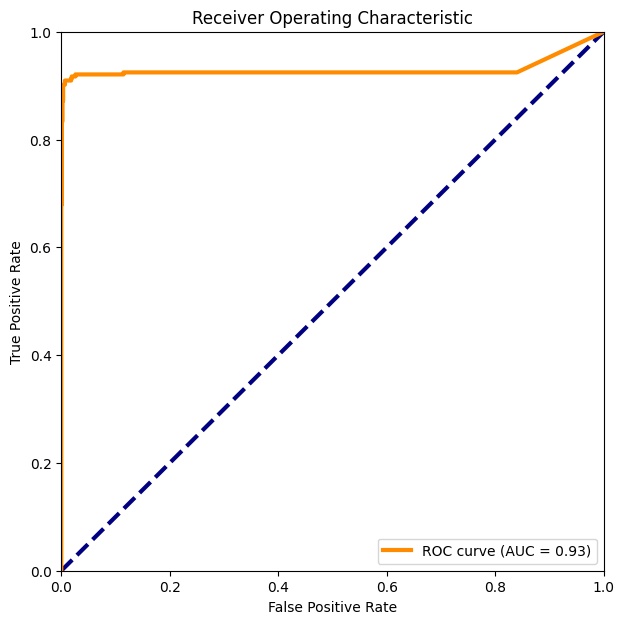

In [86]:
fpr, tpr, threshold = roc_curve(y_test, prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize = (7,7))
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--') #прямая y=x
plt.plot(fpr, tpr, color='darkorange', lw=3, label='ROC curve (AUC = %0.2f)' % roc_auc) #lw - толщина линии
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
print("Test: ")
plt.show()

In [87]:
conf_mat = confusion_matrix(y_test, y_pred)
conf_mat = pd.DataFrame(conf_mat, index = ['ham (0)', 'spam (1)'], columns = ['ham (0)', 'spam (1)']).T
conf_mat

,ham (0),spam (1)
ham (0),878,31
spam (1),3,234


In [90]:
report = classification_report(y_test, y_pred, target_names=['ham (0)', 'spam (1)'])
print(report)

              precision    recall  f1-score   support

     ham (0)       0.97      1.00      0.98       881
    spam (1)       0.99      0.88      0.93       265

    accuracy                           0.97      1146
   macro avg       0.98      0.94      0.96      1146
weighted avg       0.97      0.97      0.97      1146

